In [1]:
%reload_ext autoreload
%autoreload 2

In [ ]:
import sys, os

# Get absolute path to the project root
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), "../.."))
sys.path.append(PROJECT_ROOT)

sys.path.append("/cluster/home/herminea/mental_health_project/workspace/utils")
sys.path.append("/cluster/home/herminea/mental_health_project/workspace/scripts")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import bootstrap

from utils.io.io_results import load_fc_combined_data
from utils.functional_connectivity.fc_metrics import fc_similarity
from utils.functional_connectivity.fc_compute import bin_fcs_by_freq
from utils.functional_connectivity.fc_statistical_analysis import cohen_d, hedges_g

# --- Load combined FCs ---
RES_MVMD = "/cluster/home/herminea/mental_health_project/workspace/results/fmri_prep/mvmd/combined_fc"
RES_VLMD = "/cluster/home/herminea/mental_health_project/workspace/results/fmri_prep/vlmd/combined_fc"

In [3]:
def subject_similarity_per_band(fcs_mvmd_band, fcs_vlmd_band, common_subs, groups):
    rows = []
    for s in common_subs:
        if s in fcs_mvmd_band and s in fcs_vlmd_band:
            sim = fc_similarity(fcs_mvmd_band[s], fcs_vlmd_band[s])  # your helper (edgewise Pearson r)
            rows.append({"Subject": s, "Group": groups[s], "Similarity": sim})
    return pd.DataFrame(rows)

# Summaries per group/band + effect sizes and bootstrap CIs
def boot_ci(x, conf=0.95, n_resamples=5000, seed=0):
    x = np.asarray(x)
    x = x[~np.isnan(x)]
    if len(x) < 2:
        return (np.nan, np.nan)
    rng = np.random.default_rng(seed)
    res = bootstrap((x,), np.mean, vectorized=False, confidence_level=conf, n_resamples=n_resamples, random_state=rng)
    return res.confidence_interval.low, res.confidence_interval.high

In [4]:
subs_mvmd, fcs_by_imf_mvmd, groups, freqs_by_imf_mvmd = load_fc_combined_data(RES_MVMD)
subs_vlmd, fcs_by_imf_vlmd, groups_v, freqs_by_imf_vlmd = load_fc_combined_data(RES_VLMD)

# Ensure group dict is consistent and take common subjects
assert groups == groups_v or True  # just to remind; we’ll use groups from MVMD load
common_subs = sorted(set(groups) & set(subs_mvmd.keys()) & set(subs_vlmd.keys()))

# Frequency bands you already defined
freq_bands = {
    "Slow-5": (0.01, 0.027),
    "Slow-4": (0.027, 0.073),
    "Slow-3": (0.073, 0.198),
    "Slow-2": (0.198, 0.25),
}



[Load] Loaded 42 FC result files from /cluster/home/herminea/mental_health_project/workspace/results/fmri_prep/mvmd/combined_fc
[Load] Loaded 42 FC result files from /cluster/home/herminea/mental_health_project/workspace/results/fmri_prep/vlmd/combined_fc


In [5]:
# Reuse your bin_fcs_by_freq() and add Whole
fcs_by_band_mvmd = bin_fcs_by_freq(subs_mvmd, freq_bands)
fcs_by_band_vlmd = bin_fcs_by_freq(subs_vlmd, freq_bands)

# Add Whole band for both
fcs_by_band_mvmd["Whole"] = {s: fcs_by_imf_mvmd["whole"][s] for s in common_subs if s in fcs_by_imf_mvmd["whole"]}
fcs_by_band_vlmd["Whole"] = {s: fcs_by_imf_vlmd["whole"][s] for s in common_subs if s in fcs_by_imf_vlmd["whole"]}

# Ensure same band order
order = ["Whole", "Slow-5", "Slow-4", "Slow-3", "Slow-2"]

In [6]:
# Collect per-band results
sim_band_df = []
for band in order:
    df_band = subject_similarity_per_band(fcs_by_band_mvmd.get(band, {}), 
                                          fcs_by_band_vlmd.get(band, {}), 
                                          common_subs, groups)
    df_band["Band"] = band
    sim_band_df.append(df_band)

sim_band_df = pd.concat(sim_band_df, ignore_index=True)


rows = []
for band in order:
    dfb = sim_band_df[sim_band_df["Band"]==band]
    mdd = dfb[dfb["Group"]=="MDD"]["Similarity"].values
    hc  = dfb[dfb["Group"]=="HC"]["Similarity"].values
    mean_m, mean_h = np.nanmean(mdd), np.nanmean(hc)
    ci_m = boot_ci(mdd); ci_h = boot_ci(hc)
    g = hedges_g(mdd, hc); d = cohen_d(mdd, hc)
    rows.append({
        "Band": band,
        "Mean_MDD": mean_m, "CI_MDD_low": ci_m[0], "CI_MDD_high": ci_m[1],
        "Mean_HC":  mean_h, "CI_HC_low":  ci_h[0], "CI_HC_high":  ci_h[1],
        "Hedges_g": g, "Cohen_d": d,
        "Δ(MDD-HC)": mean_m - mean_h
    })

sim_summary = pd.DataFrame(rows)
#print(sim_summary)


/cluster/home/herminea/.conda/envs/neuro/lib/python3.10/site-packages/scipy/stats/_resampling.py:147: RuntimeWarning: invalid value encountered in scalar divide
  a_hat = 1/6 * sum(nums) / sum(dens)**(3/2)
/cluster/home/herminea/.conda/envs/neuro/lib/python3.10/site-packages/scipy/_lib/_util.py:440: DegenerateDataWarning: The BCa confidence interval cannot be calculated. This problem is known to occur when the distribution is degenerate or the statistic is np.min.
  return fun(*args, **kwargs)


### Plotting

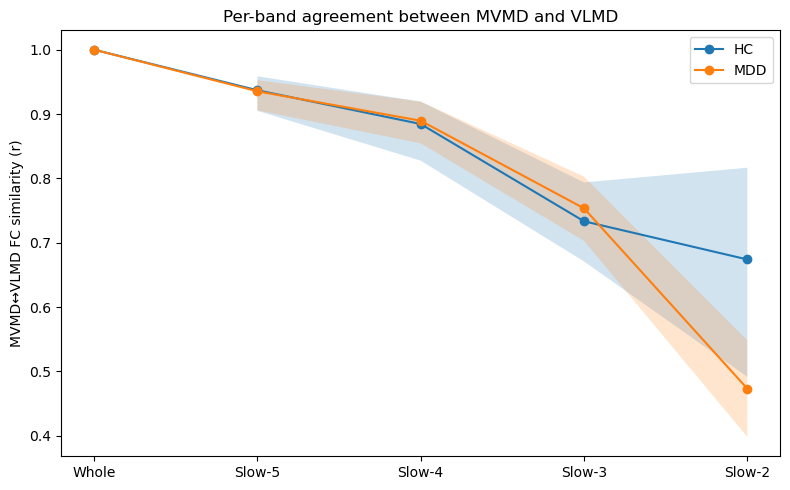

In [7]:
x = np.arange(len(order))

plt.figure(figsize=(8,5))
# HC
hc_means = sim_summary["Mean_HC"].values
hc_low   = sim_summary["CI_HC_low"].values
hc_high  = sim_summary["CI_HC_high"].values
plt.plot(x, hc_means, 'o-', label='HC')
plt.fill_between(x, hc_low, hc_high, alpha=0.2)

# MDD
mdd_means = sim_summary["Mean_MDD"].values
mdd_low   = sim_summary["CI_MDD_low"].values
mdd_high  = sim_summary["CI_MDD_high"].values
plt.plot(x, mdd_means, 'o-', label='MDD')
plt.fill_between(x, mdd_low, mdd_high, alpha=0.2)

plt.xticks(x, order)
plt.ylabel("MVMD↔VLMD FC similarity (r)")
plt.title("Per-band agreement between MVMD and VLMD")
plt.legend()
plt.tight_layout()
plt.show()
